In [1]:
#Using APRBS with a 180 degree peak to peak and two separate input signals

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import math
from simulation_tools import PRBS
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import pickle as pkl

In [3]:
df = pd.read_csv('aprbs_180ptp_2dof_log.txt')
df = df.drop(['timestamp'], axis=1)
#Centre positions at 0
df[['rot_command', 'flex_command', 'rot_cur_pos', 
    'flex_cur_pos','rot_next_pos', 'flex_next_pos']] = df[['rot_command', 'flex_command', 
                                                           'rot_cur_pos', 'flex_cur_pos', 
                                                           'rot_next_pos', 'flex_next_pos']] - 2048

#Centre velocities at 0
df[['rot_cur_vel', 'flex_cur_vel', 
    'rot_next_vel', 'flex_next_vel']] = df[['rot_cur_vel', 'flex_cur_vel', 'rot_next_vel', 'flex_next_vel']] - 1024
#Convert to radians
df = df * 2 * math.pi/4096
df.head()

,rot_command,flex_command,rot_cur_pos,flex_cur_pos,rot_next_pos,flex_next_pos,rot_cur_vel,flex_cur_vel,rot_next_vel,flex_next_vel
0,-3.141593,-3.141593,0.003068,-0.012272,0.003068,-0.012272,-1.570796,-1.570796,-1.570796,-1.570796
1,-1.216447,1.420466,0.003068,-0.012272,0.003068,-0.012272,-1.570796,-1.570796,-1.570796,-1.558524
2,-1.216447,1.420466,0.003068,-0.012272,-0.006136,-0.003068,-1.570796,-1.558524,0.061359,-1.515573
3,-1.216447,1.420466,-0.006136,-0.003068,-0.026078,0.013806,0.061359,-1.515573,0.147262,-1.441942
4,-1.216447,1.420466,-0.026078,0.013806,-0.049087,0.033748,0.147262,-1.441942,0.245437,-1.356039


In [4]:
X = df[['rot_command', 'flex_command', 'rot_cur_pos', 'flex_cur_pos', 'rot_cur_vel', 'flex_cur_vel']]
y = df[['rot_next_pos', 'flex_next_pos', 'rot_next_vel', 'flex_next_vel']]

In [5]:
X.head()

,rot_command,flex_command,rot_cur_pos,flex_cur_pos,rot_cur_vel,flex_cur_vel
0,-3.141593,-3.141593,0.003068,-0.012272,-1.570796,-1.570796
1,-1.216447,1.420466,0.003068,-0.012272,-1.570796,-1.570796
2,-1.216447,1.420466,0.003068,-0.012272,-1.570796,-1.558524
3,-1.216447,1.420466,-0.006136,-0.003068,0.061359,-1.515573
4,-1.216447,1.420466,-0.026078,0.013806,0.147262,-1.441942


In [6]:
y.head()

,rot_next_pos,flex_next_pos,rot_next_vel,flex_next_vel
0,0.003068,-0.012272,-1.570796,-1.570796
1,0.003068,-0.012272,-1.570796,-1.558524
2,-0.006136,-0.003068,0.061359,-1.515573
3,-0.026078,0.013806,0.147262,-1.441942
4,-0.049087,0.033748,0.245437,-1.356039


In [7]:
X_train = X[:8000]
X_test = X[8000:].reset_index(drop=True)
y_train = y[:8000]
y_test = y[8000:].reset_index(drop=True)

# LSTM

In [8]:
seq_len_train = 100
num_inputs = 2
num_outputs = 2
lstm = Sequential()
lstm.add(LSTM(16, batch_input_shape=(1, None, num_inputs), return_sequences=True, stateful=True))
lstm.add(Dense(num_outputs))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
lstm.compile(opt, loss='mse')
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 16)             1216      
_________________________________________________________________
dense (Dense)                (1, None, 2)              34        
Total params: 1,250
Trainable params: 1,250
Non-trainable params: 0
_________________________________________________________________


In [20]:
def run_lstm(seq_len, X, y=None):
    lstm.reset_states()

    batches = len(X)//seq_len
    outputs = np.zeros(shape=(len(X), 2))

    mse = 0
    for i in range(batches):
        lstm_input = np.array(X[i*seq_len:(i+1)*seq_len]).reshape(1, seq_len, num_inputs)
        model_output = lstm.predict(lstm_input, batch_size=1)

        if y is not None:
            lstm_labels = np.array(y[i*seq_len:(i+1)*seq_len]).reshape(1, seq_len, num_outputs)
            mse += mean_squared_error(lstm_labels[0], model_output[0])
        outputs[i*seq_len:(i+1)*seq_len, :] = model_output

    if y is not None:
        mse /= batches
        print("MSE:",mse)
    return outputs
    

In [10]:
X_train_lstm = X_train[['rot_command', 'flex_command']]
y_train_lstm = y_train[['rot_next_pos', 'flex_next_pos']]
X_test_lstm = X_test[['rot_command', 'flex_command']]
y_test_lstm = y_test[['rot_next_pos', 'flex_next_pos']]

In [11]:
batches = len(X_train_lstm)//seq_len_train
epochs = 100

In [12]:
for _ in range(epochs):
    err = 0
    for i in range(batches):
        lstm_input = np.array(X_train_lstm[i*seq_len_train:(i+1)*seq_len_train]).reshape(1, seq_len_train, num_inputs)
        lstm_labels = np.array(y_train_lstm[i*seq_len_train:(i+1)*seq_len_train]).reshape(1, seq_len_train, num_outputs)
        hist = lstm.fit(lstm_input, lstm_labels, batch_size=1, verbose=0)
        err += hist.history['loss'][0]
    err /= batches
    print(err, ',', end='')

0.39804449582006785 ,0.1786608896087273 ,0.1362521344097331 ,0.11854443167103454 ,0.10446196782868356 ,0.09276977342087775 ,0.08512660851702095 ,0.0789155375910923 ,0.07361949718324468 ,0.06909928700188175 ,0.0651968762744218 ,0.061568846157751975 ,0.057846563280327244 ,0.05407213371945545 ,0.050478344707516956 ,0.047303117642877625 ,0.04465956250205636 ,0.04256116722826846 ,0.04093134079594165 ,0.03967837728559971 ,0.038721127226017414 ,0.03797217549290508 ,0.03733952122274786 ,0.036749948014039545 ,0.036165986047126356 ,0.03558052299194969 ,0.03499836610862985 ,0.0344232483941596 ,0.03385487958439626 ,0.033290234283776955 ,0.03272478167200461 ,0.032152254733955485 ,0.031564144216827114 ,0.030949388159206136 ,0.030296346289105713 ,0.02960016089491546 ,0.02887859511829447 ,0.02817881449882407 ,0.027535420097410678 ,0.026933120167814194 ,0.02635945654765237 ,0.025828808310325257 ,0.025351622479502112 ,0.02492573135823477 ,0.024545736094296444 ,0.02420692741725361 ,0.023902719833131414 ,

### Testing on test set

MSE: 0.020511939684435744


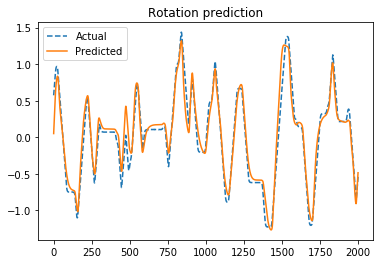

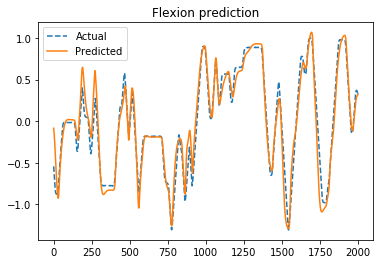

In [26]:
outputs = run_lstm(1, X_test_lstm, y_test_lstm)
rot_position = outputs[:, 0]
flex_position = outputs[:, 1]

plt.plot(y_test['rot_next_pos'], '--')
plt.plot(rot_position)
plt.legend(['Actual', 'Predicted'])
plt.title("Rotation prediction")
plt.show()

plt.plot(y_test['flex_next_pos'], '--')
plt.plot(flex_position)
plt.legend(['Actual', 'Predicted'])
plt.title("Flexion prediction")
plt.show()

### Testing on a step input

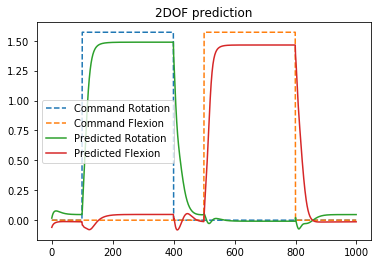

In [52]:
#Testing decoupling
step = np.zeros((1000, num_inputs))
step[100:400, 0] = math.pi/2
step[500:800, 1] = math.pi/2

outputs = run_lstm(1, step)
rot_position = outputs[:, 0]
flex_position = outputs[:, 1]

plt.plot(step, '--')
plt.plot(rot_position)
plt.plot(flex_position)
plt.legend(['Command Rotation', 'Command Flexion', 'Predicted Rotation', 'Predicted Flexion'])
plt.title("2DOF prediction")
plt.show()

### Testing on a prbs input

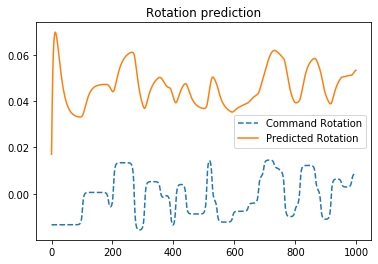

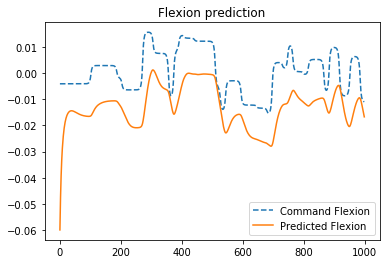

In [58]:
#Doesn't generalize to small inputs
sig_gen = PRBS()
d = np.zeros(shape=(1000, 2))

d[:, 0] = sig_gen.apply_butter(sig_gen.generate_APRBS(1000, 100, math.pi/100))
d[:, 1] = sig_gen.apply_butter(sig_gen.generate_APRBS(1000, 100, math.pi/100))

outputs = run_lstm(1, d)
rot_position = outputs[:, 0]
flex_position = outputs[:, 1]

plt.plot(d[:, 0], '--')
plt.plot(rot_position)
plt.legend(['Command Rotation', 'Predicted Rotation'])
plt.title("Rotation prediction")
plt.show()

plt.plot(d[:, 1], '--')
plt.plot(flex_position)
plt.legend(['Command Flexion', 'Predicted Flexion'])
plt.title("Flexion prediction")
plt.show()

In [31]:
lstm_weights = [lstm.layers[0].get_weights(), lstm.layers[1].get_weights()]
pkl.dump(lstm_weights, open('lstm_weights_2dof.pkl', 'wb'))

# Neural Network

In [16]:
nn = Sequential()
nn.add(Dense(8, input_shape=(6,), activation='relu'))
nn.add(Dense(4))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)
nn.compile(opt, loss='mse')
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 56        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________


In [17]:
nn.fit(X_train, y_train, epochs=100, verbose=1)

Epoch 1/100
8000/8000 [==============================] - 0s 40us/step - loss: 0.9077
Epoch 2/100
8000/8000 [==============================] - 0s 18us/step - loss: 0.1701
Epoch 3/100
8000/8000 [==============================] - 0s 19us/step - loss: 0.0459
Epoch 4/100
8000/8000 [==============================] - 0s 20us/step - loss: 0.0300
Epoch 5/100
8000/8000 [==============================] - 0s 25us/step - loss: 0.0264
Epoch 6/100
8000/8000 [==============================] - 0s 22us/step - loss: 0.0254
Epoch 7/100
8000/8000 [==============================] - 0s 21us/step - loss: 0.0248
Epoch 8/100
8000/8000 [==============================] - 0s 21us/step - loss: 0.0244
Epoch 9/100
8000/8000 [==============================] - 0s 21us/step - loss: 0.0239
Epoch 10/100
8000/8000 [==============================] - 0s 21us/step - loss: 0.0235
Epoch 11/100
8000/8000 [==============================] - 0s 21us/step - loss: 0.0233
Epoch 12/100
8000/8000 [==============================] - 0s 20

### Testing on test set

MSE: 0.29940692752741305


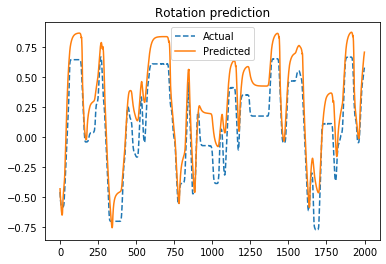

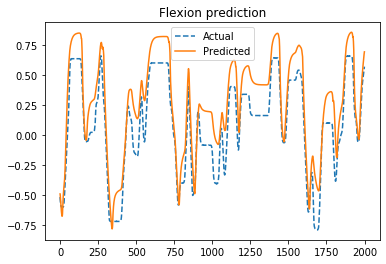

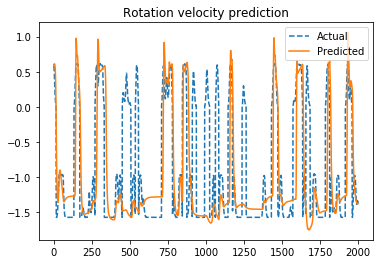

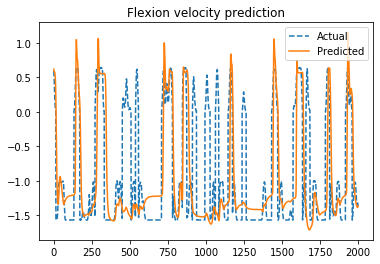

In [18]:
rot_positions = np.zeros(len(X_test))
flex_positions = np.zeros(len(X_test))
rot_velocities = np.zeros(len(X_test))
flex_velocities = np.zeros(len(X_test))

rot_cur_pos = X_test['rot_cur_pos'].iloc[0]
flex_cur_pos = X_test['flex_cur_pos'].iloc[0]
rot_cur_vel = X_test['rot_cur_vel'].iloc[0]
flex_cur_vel = X_test['flex_cur_vel'].iloc[0]
mse = 0
for i in range(len(X_test)):
    rot_positions[i] = rot_cur_pos
    flex_positions[i] = flex_cur_pos
    rot_velocities[i] = rot_cur_vel
    flex_velocities[i] = flex_cur_vel

    rot_command = X_test['rot_command'].iloc[i]
    flex_command = X_test['flex_command'].iloc[i]

    model_input = np.array([[rot_command, flex_command, rot_cur_pos, flex_cur_pos, rot_cur_vel, flex_cur_vel]])
    model_output = nn.predict(model_input, batch_size=1)[0]
    rot_cur_pos = model_output[0]
    flex_cur_pos = model_output[1]
    rot_cur_vel = model_output[2]
    flex_cur_vel = model_output[3]
    
    mse += mean_squared_error(y_test.iloc[i], model_output)
mse /= len(X_test)
print("MSE:",mse)

plt.plot(y_test['rot_next_pos'], '--')
plt.plot(rot_positions)
plt.legend(['Actual', 'Predicted'])
plt.title("Rotation prediction")
plt.show()

plt.plot(y_test['flex_next_pos'], '--')
plt.plot(flex_positions)
plt.legend(['Actual', 'Predicted'])
plt.title("Flexion prediction")
plt.show()

plt.plot(y_test['rot_next_vel'], '--')
plt.plot(rot_velocities)
plt.legend(['Actual', 'Predicted'])
plt.title("Rotation velocity prediction")
plt.show()

plt.plot(y_test['flex_next_vel'], '--')
plt.plot(flex_velocities)
plt.legend(['Actual', 'Predicted'])
plt.title("Flexion velocity prediction")
plt.show()
